In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import cv2

In [5]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            print(coco_annotation[i]['bbox'])
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            width = coco_annotation[i]['bbox'][2]
            height = coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, width, height])
            # Inside the loop where bounding boxes are plotted

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd


        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [6]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [7]:
# path to your own data and coco file
train_data_dir = '/content/drive/MyDrive/DL_Annotated_Dataset/Final_annotated_images/train'
train_coco = '/content/drive/MyDrive/DL_Annotated_Dataset/Annotations/New_json_updated/updated_train_data.json'
val_data_dir = '/content/drive/MyDrive/DL_Annotated_Dataset/Final_annotated_images/val'
val_coco = '/content/drive/MyDrive/DL_Annotated_Dataset/Annotations/New_json_updated/updated_val_data.json'

# create own Dataset
my_dataset_train = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )
# create own Dataset
my_dataset_val = myOwnDataset(root=val_data_dir,
                          annotation=val_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# own DataLoader
data_loader_train = torch.utils.data.DataLoader(my_dataset_train,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)
# own DataLoader
data_loader_val = torch.utils.data.DataLoader(my_dataset_val,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=2.08s)
creating index...
index created!
loading annotations into memory...
Done (t=0.82s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [13]:
# Function to plot images with bounding boxes
def plot_images_with_boxes(images, annotations):
    fig, axes = plt.subplots(1, len(images), figsize=(50, 50))
    axes = np.array([axes]) if len(images) == 1 else axes

    for i, (img, annotation) in enumerate(zip(images, annotations)):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = cv2.resize(img, (1600, 896)) # resizing the image as this would be input to the backbone
        axes[i].imshow(img)
        axes[i].set_axis_off()

        for bbox in annotation['boxes']:

            xmin, ymin, width, height = bbox.tolist()
            xmin = xmin//2.4
            width = width//2.4              # mainiting the aspect ratio
            ymin = ymin//2.41
            height = height//2.41


            rect = patches.Rectangle((xmin, ymin), width, height,
                                     linewidth=5, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)

    plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[194, 446, 16, 15]
[1651, 1476, 10, 18]
[868, 277, 12, 11]
[194, 446, 16, 15]
[1651, 1476, 10, 18]
[868, 277, 12, 11]
[194, 446, 16, 15]
[1651, 1476, 10, 18]
[868, 277, 12, 11]
[194, 446, 16, 15]
[1651, 1476, 10, 18]
[868, 277, 12, 11]
[194, 446, 16, 15]
[1651, 1476, 10, 18]
[868, 277, 12, 11]
[439, 1742, 9, 17]
[439, 1742, 9, 17]
[439, 1742, 9, 17]
[439, 1742, 9, 17]
[439, 1742, 9, 17][1310, 884, 18, 16]

[1310, 884, 18, 16]
[1310, 884, 18, 16]
[439, 1742, 9, 17]
[1310, 884, 18, 16][439, 1742, 9, 17]

[1310, 884, 18, 16][439, 1742, 9, 17]
[439, 1742, 9, 17]

[1310, 884, 18, 16][439, 1742, 9, 17]

[1310, 884, 18, 16]
[439, 1742, 9, 17][1310, 884, 18, 16]

[1515, 1309, 26, 13][1310, 884, 18, 16]

[1963, 1364, 17, 19][1310, 884, 18, 16]

[1515, 1309, 26, 13][1310, 884, 18, 16]

[1963, 1364, 17, 19]
[1515, 1309, 26, 13]
[1963, 1364, 17, 19]
[1515, 1309, 26, 13]
[1963, 1364, 17, 19]
[1515, 1309, 26, 13]
[1963, 1364, 17, 19]
[1515, 1309, 26, 13]
[1963, 1364, 17, 19]
[3358, 585, 8, 11]
[3358

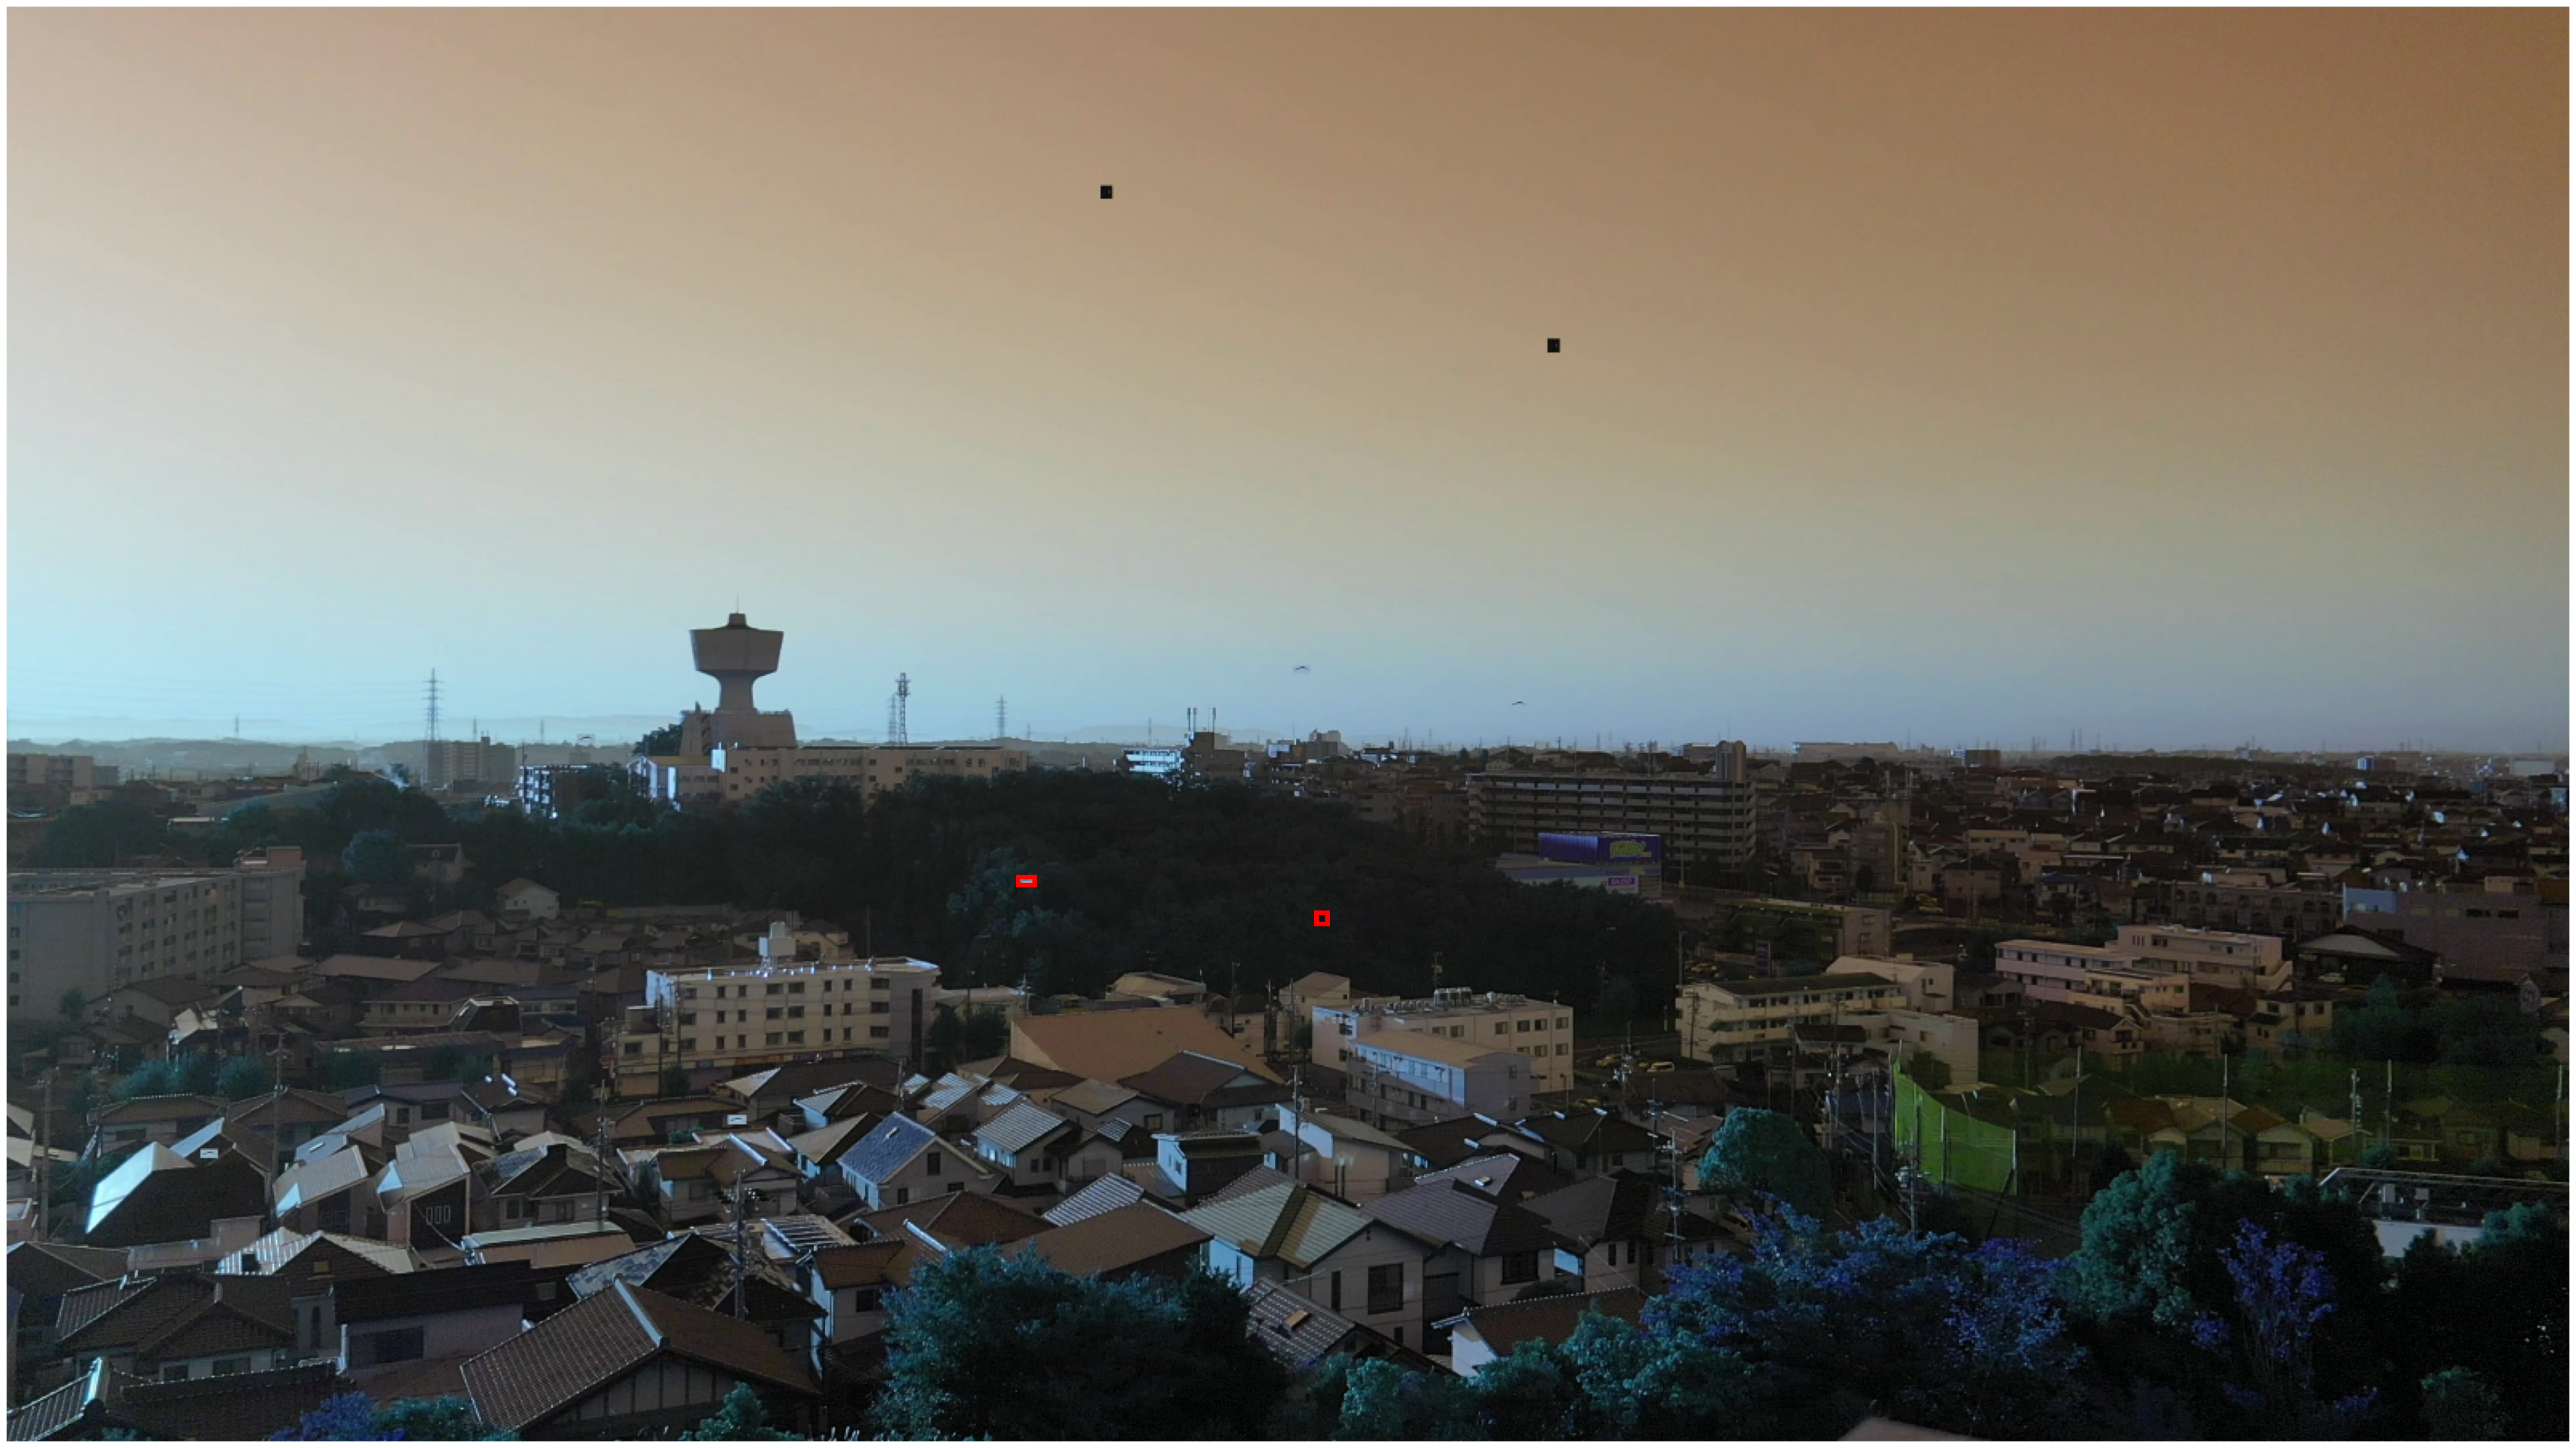

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[{'boxes': tensor([[1515., 1309.,   26.,   13.],
        [1963., 1364.,   17.,   19.],
        [1515., 1309.,   26.,   13.],
        [1963., 1364.,   17.,   19.],
        [1515., 1309.,   26.,   13.],
        [1963., 1364.,   17.,   19.],
        [1515., 1309.,   26.,   13.],
        [1963., 1364.,   17.,   19.],
        [1515., 1309.,   26.,   13.],
        [1963., 1364.,   17.,   19.],
        [1515., 1309.,   26.,   13.],
        [1963., 1364.,   17.,   19.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([8899]), 'area': tensor([338., 323., 338., 323., 338., 323., 338., 323., 338., 323., 338., 323.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}]


In [20]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# DataLoader is iterable over Dataset
# cnt =0
for imgs, annotations in data_loader_val:
    imgs = list(img.to(device) for img in imgs)
    print(imgs)
    print("wait")
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    plot_images_with_boxes(imgs, annotations)
    print(annotations)
    # print(imgs[0].shape)

    break

In [19]:
print(data_loader_train)